In [72]:
import numpy as np
from scipy import signal
from scipy.fft import fft, fftfreq, irfft, dct, idct
import cv2
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

import sig_analize as san
import generate_areas as ga
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
dir_path = './drop-250925-1'
img_path_list = [dir_path + '/'+ f for f in os.listdir(dir_path) if f.endswith('.jpg')]
img_path_list.sort()
img_path_list

['./drop-250925-1/160.jpg',
 './drop-250925-1/180.jpg',
 './drop-250925-1/200.jpg',
 './drop-250925-1/220.jpg',
 './drop-250925-1/240.jpg',
 './drop-250925-1/260.jpg',
 './drop-250925-1/280.jpg']

In [27]:
json_path = 'sequence.txt'

ga.choose_multy(img_path_list, json_path, mode='common')

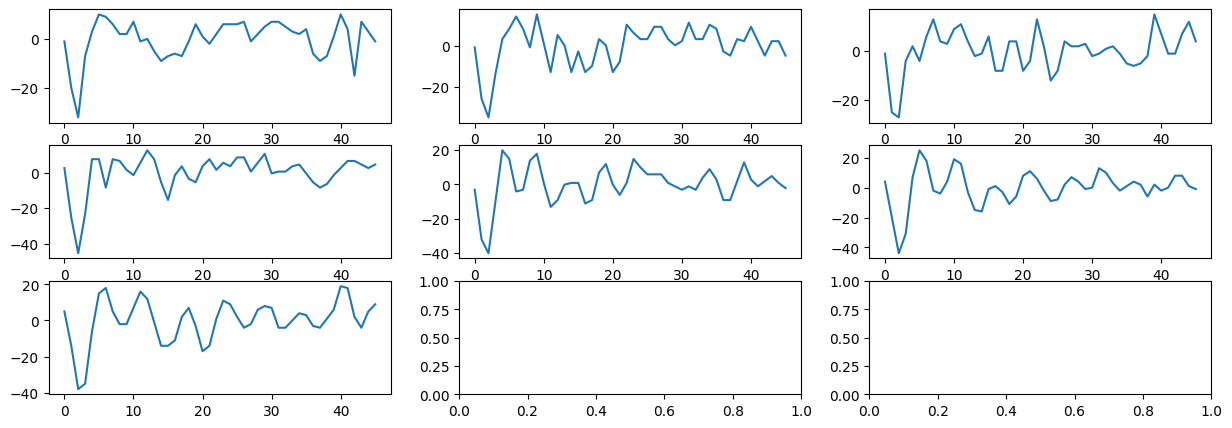

In [28]:
# upload ntencity distributions from json file and
# look at the integral intencity distribution plotted

with open(json_path,'r') as f:
    imgs = json.load(f)[:-1]

img_count = len(imgs)
row_count = (img_count+3-img_count%3)//3

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(imgs[i])

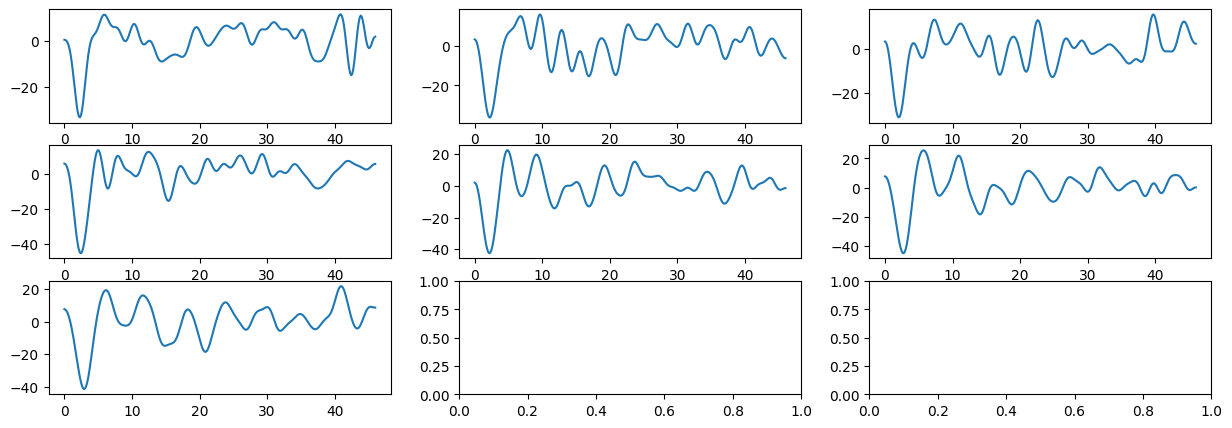

In [29]:
# approximate the graphs with sums of cosinusoids using dct
# and plot the smoother versions 

sig_len = len(imgs[0]) # for mode='commom' length is the same for all signals

N = 300
fs = 0.5*N/sig_len

coeffs = [dct(sig) for sig in imgs]
sig_sm = [san.fourie_restore(coeff, sig_len, fs, N, mode='cos') for coeff in coeffs]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(*sig_sm[i])

In [76]:
# filtering original signals with san.my_butter
# applying signal.hilbert to the filtered signal 
# plot spectral density destribution and filter responce to monitor

fs = 1
fs_niq = 0.5*fs
sig_x = np.arange(sig_len)


# function applyes butterwort filter  using my_butter
# computes instant phase using hilbert transform
# plots filtered signal, instant phase and 
# in the third column displays the probability dencity distribution along with
# Wn for the filter and filter responce 
def plot_flt_res(sig_list, fs, rel_h, nperseg_c):

    img_count = len(sig_list)
    sig_len = len(sig_list[0])

    sig_x = np.arange(sig_len)*fs

    
    fig, ax = plt.subplots(img_count, 3, figsize=(12,4*img_count))
    i = 0

    phase_vel = []

    for sig_y in sig_list:


        fxx, Pxx_den = signal.welch(np.real(sig_y), fs = fs, nperseg=int(sig_len*nperseg_c)) # sampling frequency
        fxx_l = len(fxx)

        den_peak = np.argmax(Pxx_den)
        res = signal.peak_widths(Pxx_den, [den_peak], rel_height=rel_h)
        Wn = [res[2]*0.5*fs/fxx_l,res[3]*0.5*fs/fxx_l]
    
        b, a = san.my_butter(sig_y, N=4, fs=fs, rel_h=rel_h, nperseg=int(sig_len*nperseg_c))# sampling frequency
        w, h = signal.freqz(b, a, fs = fs)
        sig_flt = signal.filtfilt(b, a, sig_y, method='gust') 


        ax[i][0].plot(sig_x, sig_flt)


        anal_y = signal.hilbert(np.real(sig_flt))
        instant_phase = np.unwrap(np.angle(anal_y))
        phase_vel.append(san.phase_vel(instant_phase[5:-5], dt = 1/fs))

        ax[i][1].plot(sig_x, instant_phase)
        ax[i][1].set_title(f" phase_vel: {phase_vel[i]}")

        ax[i][2].plot(fxx, Pxx_den/np.max(Pxx_den))
        ax[i][2].hlines(res[1]/np.max(Pxx_den), *Wn, color= 'C2')
        ax[i][2].plot(w, np.abs(h))
        ax[i][2].set_xlim(-0.01, 0.51)

        i = i+1

    return phase_vel



# use highpass filter on the signal

#plot_flt_res(sig_h, fs=1, rel_h=0.5)

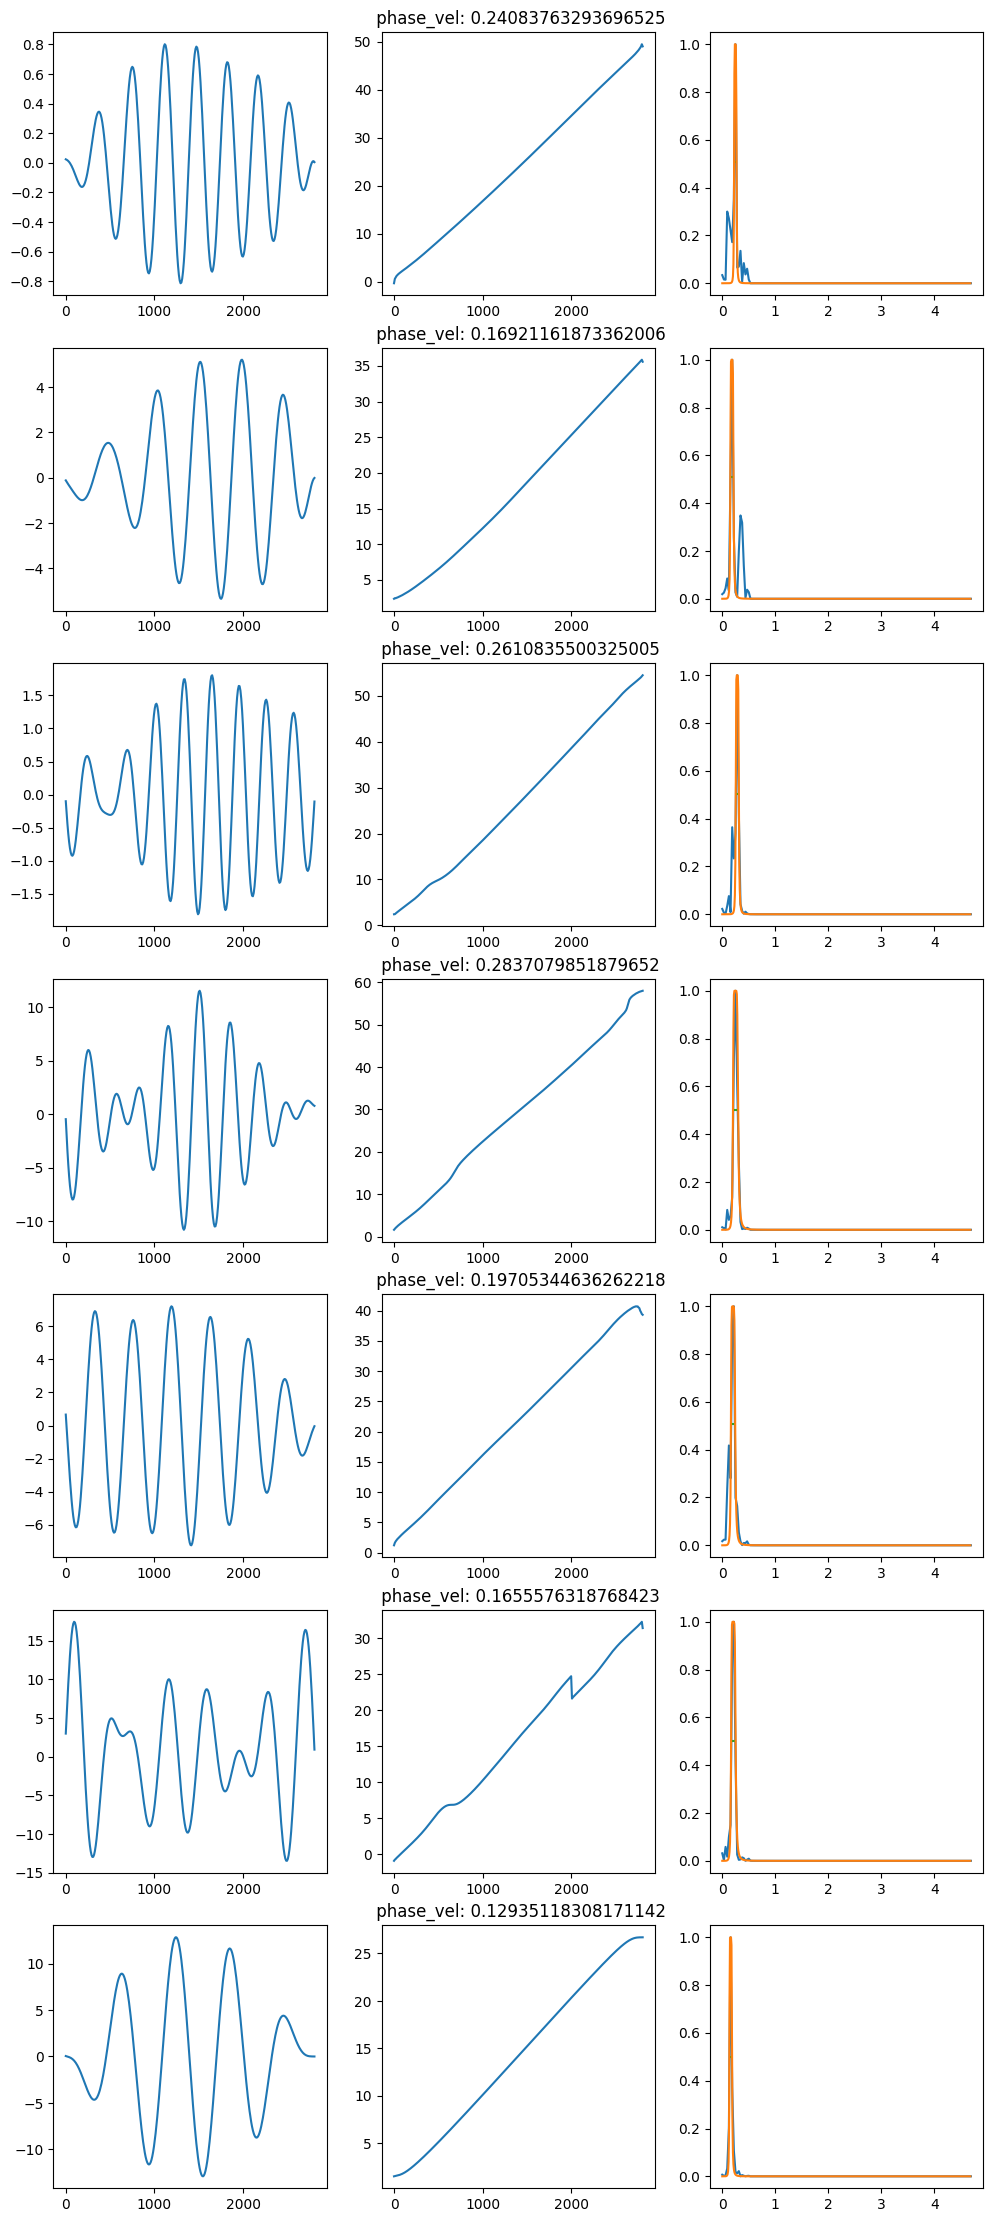

In [21]:
# filtering smoothed signals with san.my_butter
# applying signal.hilbert to the filtered signal 
# plot spectral density destribution and filter responce to monitor

fs = N/sig_len
sig_y = [s[1] for s in sig_h_sm]

plot_flt_res(sig_y, fs=fs, rel_h=0.5)

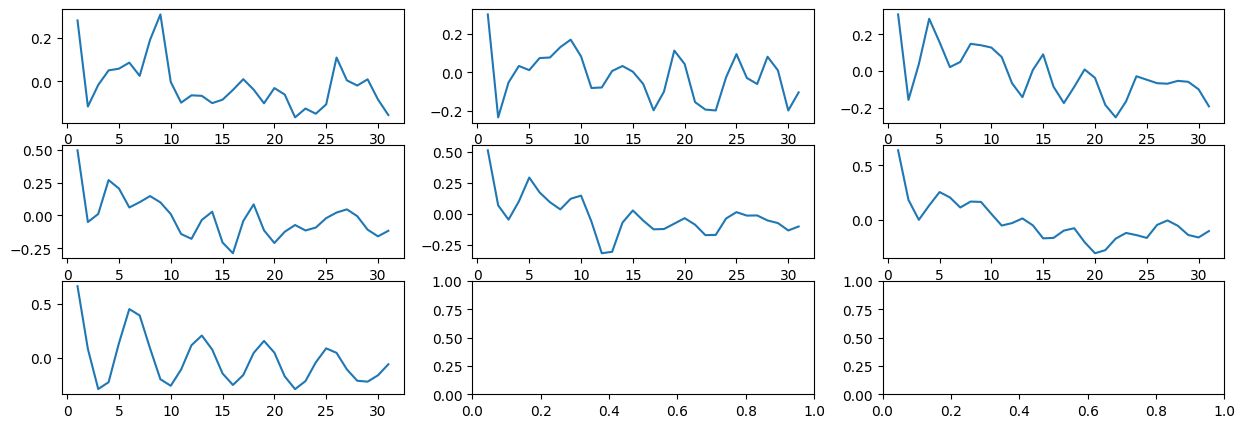

In [14]:
# Let's look at autocorrelation functions of original signals
sig_y = [s[1] for s in sig_sm]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(*san.auto_corr(imgs[i], sig_len, dt=1))

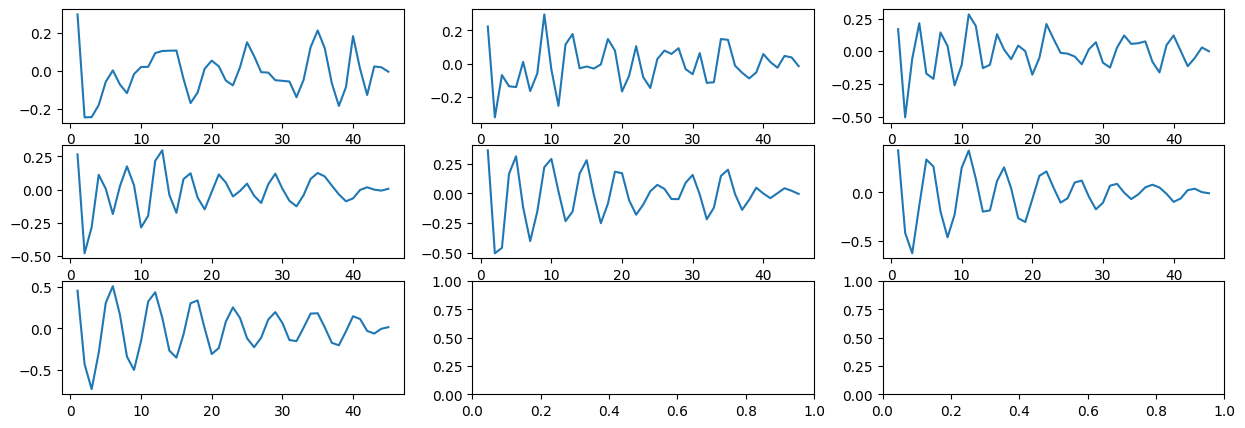

In [52]:
# to make peaks more prominent it is nesessary to
# remove low frequencies from the signals
# we will use san.my_butter_high to create high pass filter
fs=1
nl = 3
f_min = nl/sig_len
border = 4

bh, ah = signal.butter(border, f_min, btype = 'highpass', fs=fs)
sig_h = [signal.filtfilt(bh, ah, img, method='gust') for img in imgs]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(*san.auto_corr(sig_h[i], sig_len, dt=1))

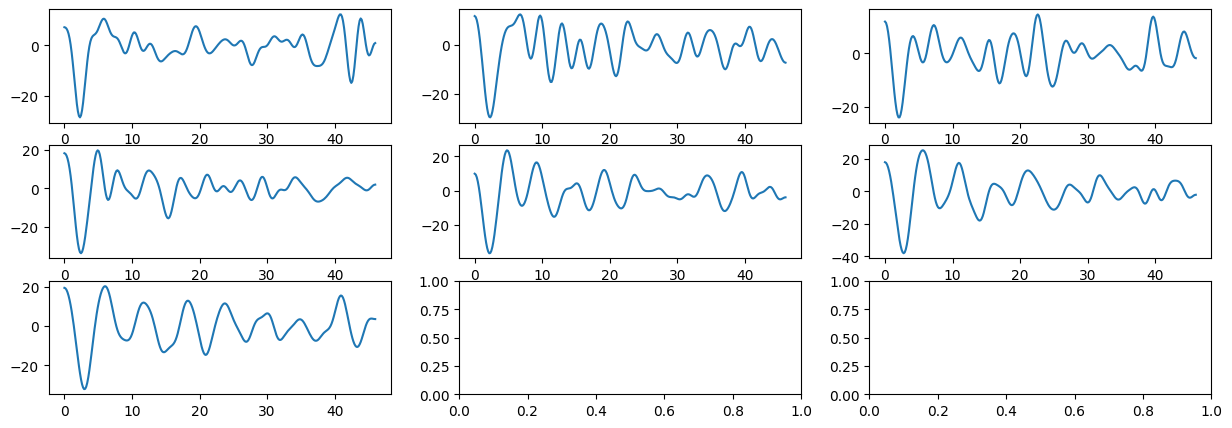

In [53]:
N = 300
fs = N/sig_len

coeffs = [dct(sig) for sig in sig_h]
sig_h_sm = [san.fourie_restore(coeff, sig_len, fs, N, mode='cos') for coeff in coeffs]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(*sig_h_sm[i])

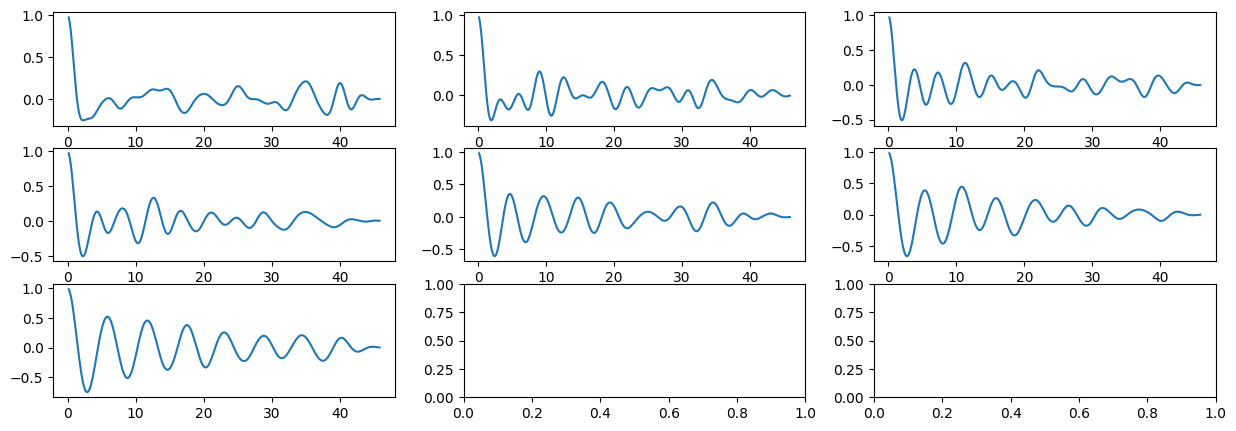

In [56]:
sig_h_sm_y = [s[1] for s in sig_h_sm]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

cor_res =  [san.auto_corr(sig_h_sm_y[i], N, dt=1/fs) for i in range(img_count)]

for i in range(img_count):
    ax[i//3][i%3].plot(*cor_res[i])

In [58]:
peak_counts = [san.peak_counter(cor[1])[0] for cor in cor_res]
print(peak_counts)

[12, 13, 11, 10, 9, 8, 8]


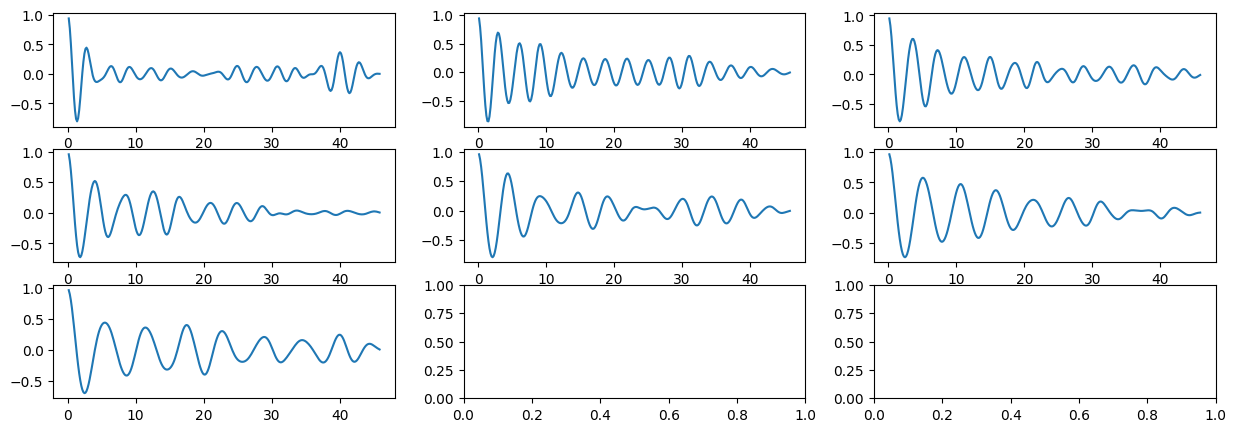

In [65]:
# to make peaks more prominent it is nesessary to
# remove low frequencies from the signals
# we will use san.my_butter_high to create high pass filter
# !!! here we use nl = number of peaks in autocorrelation function
N = 300
fs = N/sig_len
border = 4

sig_h = []

for i in range(img_count):
    nl = peak_counts[i]
    f_min = nl/sig_len


    bh, ah = signal.butter(border, f_min, btype = 'highpass', fs=fs)
    sig_h.append(signal.filtfilt(bh, ah, sig_h_sm_y[i], method='gust'))

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(*san.auto_corr(sig_h[i], N, dt=1/fs))

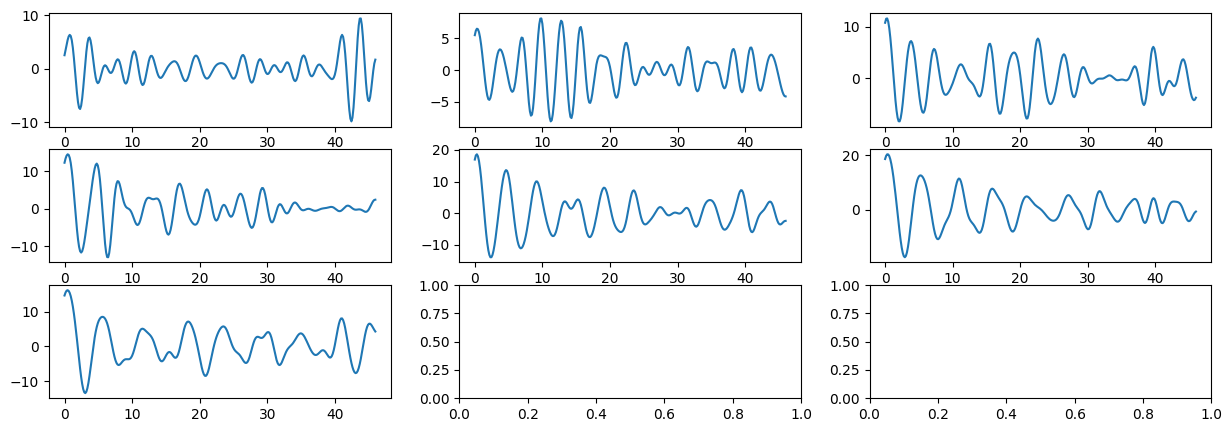

In [66]:
fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(sig_h_sm[0][0], sig_h[i])



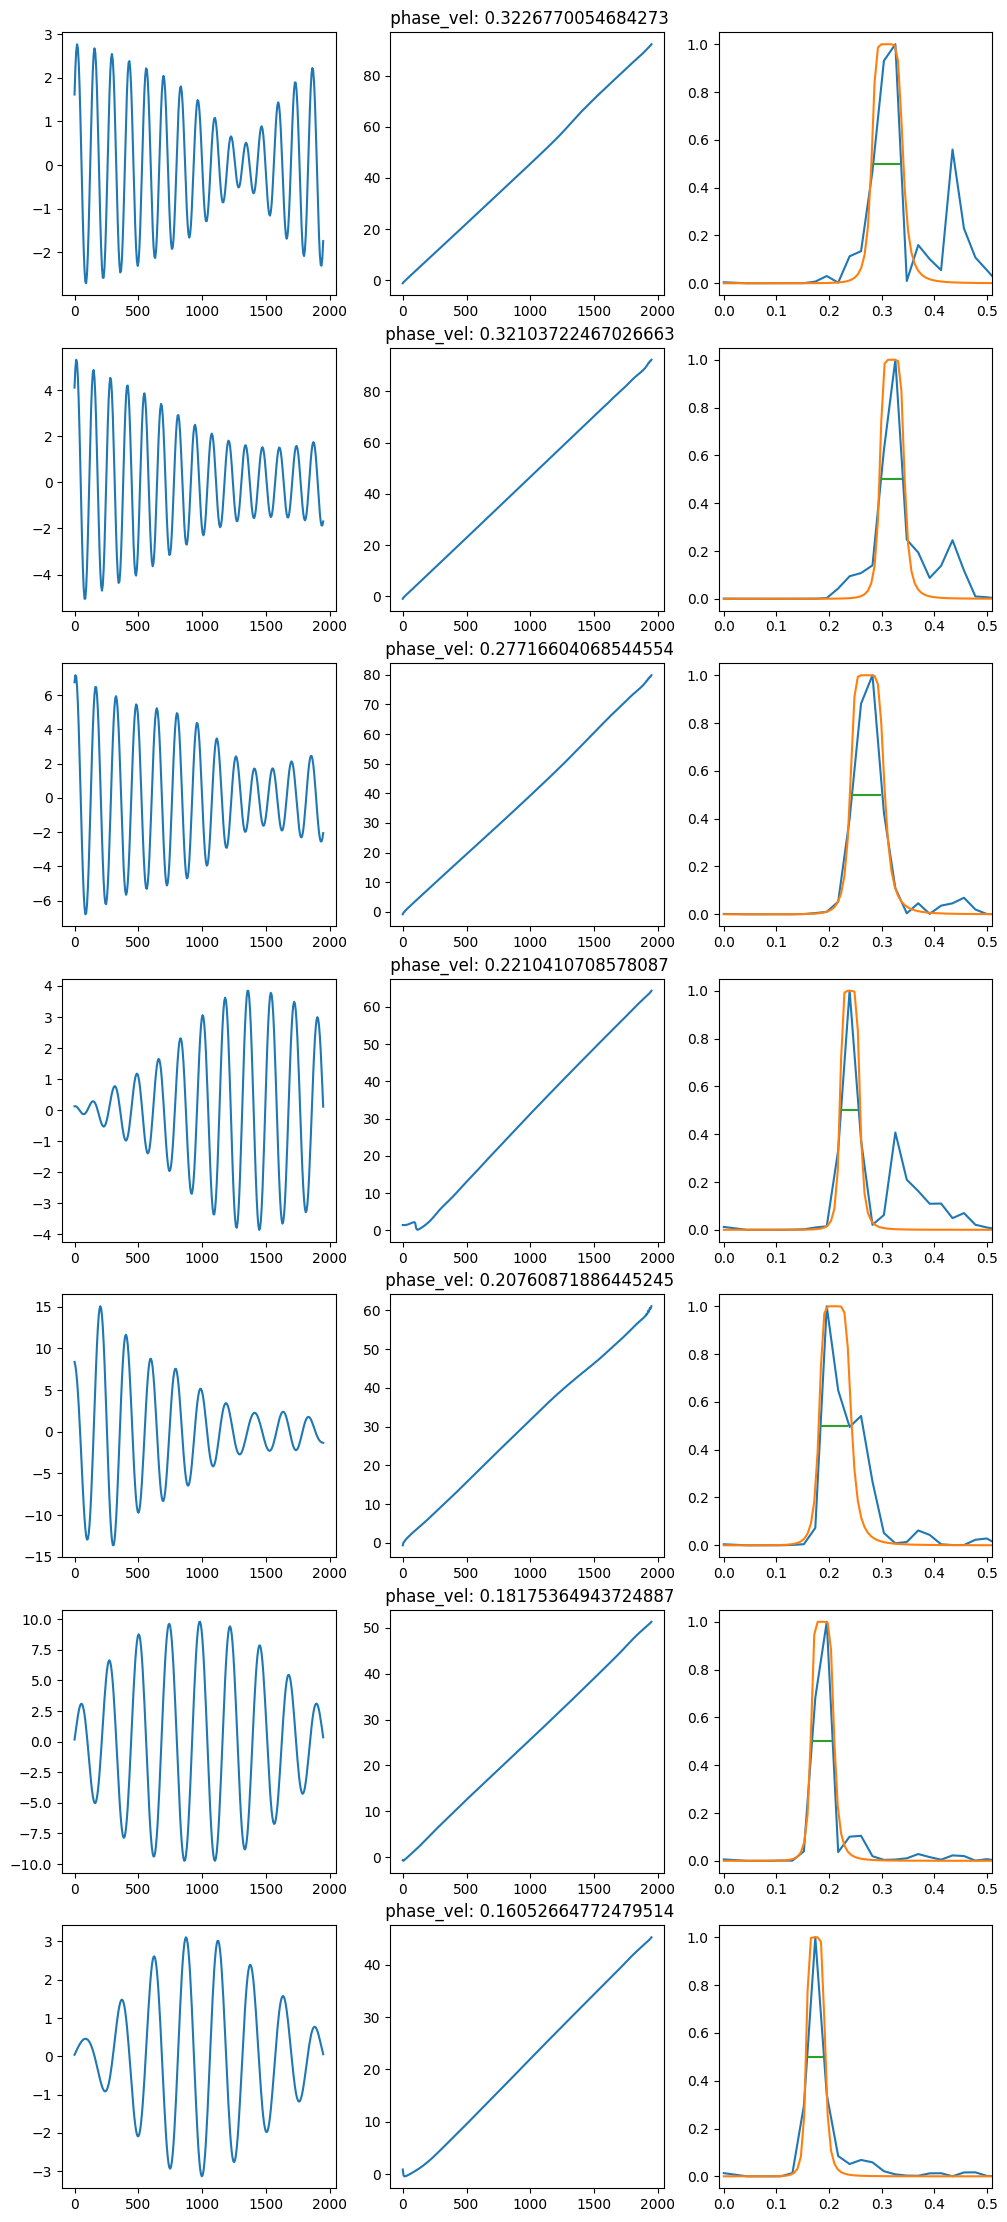

In [80]:
N = 300
fs = N/sig_len
phase_vel = plot_flt_res(sig_h, fs=fs, rel_h=0.5, nperseg_c=1)

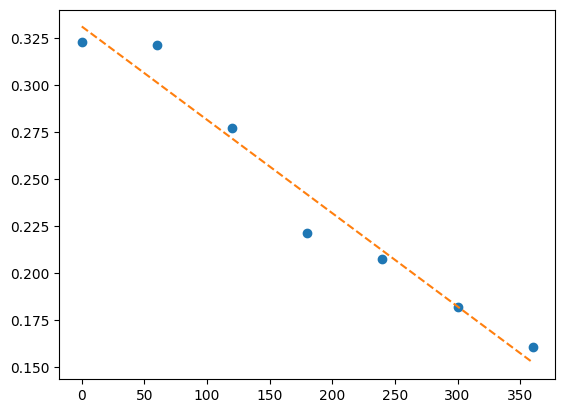

In [89]:
time = np.arange(img_count)*3*20

slope, intercept = np.polyfit(time, phase_vel, 1)
phase_vel_line = time*slope + intercept

plt.figure()
plt.plot(time, np.array(phase_vel), 'o')
plt.plot(time, phase_vel_line, '--')

In [85]:
print(slope)

-0.0004967711580463839
